# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)



C:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH='data/rossmann-store-sales/'

!dir data\rossmann-store-sales

 Volume in drive C has no label.
 Volume Serial Number is C6AF-373F

 Directory of C:\Varun\Project\fastai\courses\dl1\data\rossmann-store-sales

09/19/2018  04:55 AM    <DIR>          .
09/19/2018  04:55 AM    <DIR>          ..
09/18/2018  04:48 PM        93,131,456 df
01/10/2017  09:16 PM            86,605 googletrend.csv
09/18/2018  04:54 PM       555,587,272 joined
09/18/2018  04:52 PM       661,270,840 joined_postmergewithdf
09/18/2018  04:54 PM        26,830,176 joined_test
09/18/2018  04:53 PM        26,501,392 joined_test_postmergewithdf
09/19/2018  04:56 AM    <DIR>          models
09/29/2015  03:48 PM           317,611 sample_submission.csv
01/10/2017  06:19 PM               265 state_names.csv
09/29/2015  03:48 PM            45,010 store.csv
01/06/2017  03:17 PM             9,051 store_states.csv
09/29/2015  03:48 PM         1,427,425 test.csv
09/19/2018  04:55 AM    <DIR>          tmp
09/29/2015  03:48 PM        38,057,952 train.csv
01/10/2017  09:13 PM         1,518,814 we

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [4]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [4]:
glob(f"{PATH}/*.csv")

['data/rossmann-store-sales\\googletrend.csv',
 'data/rossmann-store-sales\\sample_submission.csv',
 'data/rossmann-store-sales\\state_names.csv',
 'data/rossmann-store-sales\\store.csv',
 'data/rossmann-store-sales\\store_states.csv',
 'data/rossmann-store-sales\\test.csv',
 'data/rossmann-store-sales\\train.csv',
 'data/rossmann-store-sales\\weather.csv']

In [ ]:
#concat_csvs('googletrend')
#concat_csvs('weather')

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [5]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [7]:
from IPython.display import HTML, display

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [8]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [10]:
for t in tables: display(DataFrameSummary(t).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,BadenWuerttemberg,BE
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [11]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [12]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [13]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [14]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [15]:
weather = join_df(weather, state_names, "file", "StateName")

In [16]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW


In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [17]:
googletrend.head()

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


In [18]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [19]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [20]:
googletrend.head()

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [21]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [22]:
trend_de.head()

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
148,Rossmann_DE,2012-12-02 - 2012-12-08,77,2012-12-02,None,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
149,Rossmann_DE,2012-12-09 - 2012-12-15,76,2012-12-09,None,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
150,Rossmann_DE,2012-12-16 - 2012-12-22,85,2012-12-16,None,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
151,Rossmann_DE,2012-12-23 - 2012-12-29,59,2012-12-23,None,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
152,Rossmann_DE,2012-12-30 - 2013-01-05,61,2012-12-30,None,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why not just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [23]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [24]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [25]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,BE
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,SN


In [26]:
display(train.columns)
display(test.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed'],
      dtype='object')

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

In [28]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [29]:
joined.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State'],
      dtype='object')

In [31]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,BE
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,SN


In [32]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [33]:
display(joined.head())
display(joined_test.head())
joined.columns

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day_y,Dayofweek_y,Dayofyear_y,Is_month_end_y,Is_month_start_y,Is_quarter_end_y,Is_quarter_start_y,Is_year_end_y,Is_year_start_y,Elapsed_y
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,2,6,214,False,False,False,False,False,False,1438473600


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Day_y,Dayofweek_y,Dayofyear_y,Is_month_end_y,Is_month_start_y,Is_quarter_end_y,Is_quarter_start_y,Is_year_end_y,Is_year_start_y,Elapsed_y
0,1,1,4,2015-09-17,1.0,1,False,0,2015,9,...,20,6,263,False,False,False,False,False,False,1442707200
1,2,3,4,2015-09-17,1.0,1,False,0,2015,9,...,20,6,263,False,False,False,False,False,False,1442707200
2,3,7,4,2015-09-17,1.0,1,False,0,2015,9,...,20,6,263,False,False,False,False,False,False,1442707200
3,4,8,4,2015-09-17,1.0,1,False,0,2015,9,...,20,6,263,False,False,False,False,False,False,1442707200
4,5,9,4,2015-09-17,1.0,1,False,0,2015,9,...,20,6,263,False,False,False,False,False,False,1442707200


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'Dayofweek_y',
       'Dayofyear_y', 'Is_month_end_y', 'Is_month_start_y', 'Is_quarter_end_y',
       'Is_quarter_start_y', 'Is_year_end_y', 'Is_year_start_y', 'Elapsed_y'],
      dtype='object')

In [34]:
## trend_de is for entire Germany.
trend_de.head()

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
148,Rossmann_DE,2012-12-02 - 2012-12-08,77,2012-12-02,None,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
149,Rossmann_DE,2012-12-09 - 2012-12-15,76,2012-12-09,None,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
150,Rossmann_DE,2012-12-16 - 2012-12-22,85,2012-12-16,None,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
151,Rossmann_DE,2012-12-23 - 2012-12-29,59,2012-12-23,None,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
152,Rossmann_DE,2012-12-30 - 2013-01-05,61,2012-12-30,None,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


In [35]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
#len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

In [38]:
#display(joined.head())
#display(joined_test.head())
#joined.columns
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [39]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [40]:
joined.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'Dayofweek_y',
       'Dayofyear_y', 'Is_month_end_y', 'Is_month_start_y', 'Is_quarter_end_y',
       'Is_quarter_start_y', 'Is_year_end_y', 'Is_year_start_y', 'Elapsed_y',
       'file_DE', 'week_DE', 'trend_DE', 'Date_DE', 'State_DE', 'Month_DE',
       'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE', 'Is_month_end_DE',
       'Is_month_start_DE', 'Is_quarter_end_DE', 'Is_quarter_start_DE',
       'Is_year_end_DE', 'Is_year_start_DE',

In [41]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [42]:
joined.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'file_DE', 'week_DE', 'trend_DE', 'Date_DE',
       'State_DE', 'Month_DE', 'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE',
       'Is_month_end_DE', 'Is_month_start_DE', 'Is_quarter_end_DE',
       'Is_quarter_start_DE', 'Is_year_end_DE', 'Is_year_start_DE',
       'Elapsed_DE', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea

In [44]:
display(joined[joined["CompetitionOpenSinceYear"].isnull()].shape)
display(joined[joined["CompetitionOpenSinceYear"].isna()].shape)

(323348, 74)

(323348, 74)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [45]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [46]:
joined.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'file_DE', 'week_DE', 'trend_DE', 'Date_DE',
       'State_DE', 'Month_DE', 'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE',
       'Is_month_end_DE', 'Is_month_start_DE', 'Is_quarter_end_DE',
       'Is_quarter_start_DE', 'Is_year_end_DE', 'Is_year_start_DE',
       'Elapsed_DE', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea

In [48]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    #df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [49]:
columns = ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSince', 'Date']
joined[columns].head()

,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpenSince,Date
0,2008,9,2008-09-15,2015-07-31
1,2007,11,2007-11-15,2015-07-31
2,2006,12,2006-12-15,2015-07-31
3,2009,9,2009-09-15,2015-07-31
4,2015,4,2015-04-15,2015-07-31


In [51]:
for df in (joined, joined_test):
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [52]:
columns = ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSince', 'Date', 'CompetitionDaysOpen']
joined[columns].head()

,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpenSince,Date,CompetitionDaysOpen
0,2008,9,2008-09-15,2015-07-31,2510
1,2007,11,2007-11-15,2015-07-31,2815
2,2006,12,2006-12-15,2015-07-31,3150
3,2009,9,2009-09-15,2015-07-31,2145
4,2015,4,2015-04-15,2015-07-31,107


We'll replace some erroneous / outlying data.

In [55]:
df.loc[(df.CompetitionDaysOpen < 0) | (df.CompetitionOpenSinceYear<1990)][columns].head()

,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpenSince,Date,CompetitionDaysOpen
7,1900,1,1900-01-15,2015-09-17,42248
8,1900,1,1900-01-15,2015-09-17,42248
11,1900,1,1900-01-15,2015-09-17,42248
12,1900,1,1900-01-15,2015-09-17,42248
15,1900,1,1900-01-15,2015-09-17,42248


In [56]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [57]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5],
      dtype=int64)

In [58]:
joined_test.CompetitionMonthsOpen.unique()

array([24, 11,  0, 18, 19, 17, 21, 13,  9,  2, 14,  4,  6, 12,  3, 16, 10, 15, 20, 22,  5, 23,  7,  1,  8],
      dtype=int64)

Same process for Promo dates.

In [66]:
joined[["Promo2SinceWeek", "Promo2SinceYear", 'Date']].head()

,Promo2SinceWeek,Promo2SinceYear,Date
0,1,1900,2015-07-31
1,13,2010,2015-07-31
2,14,2011,2015-07-31
3,1,1900,2015-07-31
4,1,1900,2015-07-31


In [59]:
t = pd.to_datetime(joined.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
t.head()

0   1900-01-01
1   2010-03-29
2   2011-04-04
3   1900-01-01
4   1900-01-01
dtype: datetime64[ns]

In [60]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [61]:
joined[["Promo2SinceWeek", "Promo2SinceYear", 'Date','Promo2Since', 'Promo2Days']].head()

,Promo2SinceWeek,Promo2SinceYear,Date,Promo2Since,Promo2Days
0,1,1900,2015-07-31,1900-01-01,42214
1,13,2010,2015-07-31,2010-03-29,1950
2,14,2011,2015-07-31,2011-04-04,1579
3,1,1900,2015-07-31,1900-01-01,42214
4,1,1900,2015-07-31,1900-01-01,42214


In [62]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    ## If Promo is on for more than 6 month just use 25 week number for denoting the same.  
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [63]:
## This is crtificate piece, which basically writes to the disk things that is in memory as is.
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [83]:
#np.timedelta64(1, 'D')
t=[]
t.append(((np.datetime64('2018-01-10') - np.datetime64()).astype('timedelta64[D]'))/np.timedelta64(1, 'D'))
t

[nan]

In [66]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [67]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [68]:
#df = train[columns]
df = train[columns].append(test[columns])

In [71]:
tables = [train, test, df]
for t in tables:
    display(t[columns].head())


,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1


,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-09-17,1,1,False,0
1,2015-09-17,3,1,False,0
2,2015-09-17,7,1,False,0
3,2015-09-17,8,1,False,0
4,2015-09-17,9,1,False,0


,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1


Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `get_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [72]:
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1


In [85]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
display(df.head())
get_elapsed(fld, 'Before')
display(df.sort_values(['Store', 'Date']).head())

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-09-17,1,1,False,0,13.0,NaN
856,2015-09-16,1,1,False,0,12.0,NaN
1712,2015-09-15,1,1,False,0,11.0,NaN
2568,2015-09-14,1,1,False,0,10.0,NaN
3424,2015-09-13,1,0,False,0,9.0,NaN


,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
1016095,2013-01-01,1,0,True,1,0.0,0.0
1014980,2013-01-02,1,0,False,1,0.0,0.0
1013865,2013-01-03,1,0,False,1,0.0,0.0
1012750,2013-01-04,1,0,False,1,0.0,0.0
1011635,2013-01-05,1,0,False,1,0.0,0.0


We'll do this for two more fields.

In [86]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [87]:
display(df.sort_values(['Store', 'Date']).head())

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday
1016095,2013-01-01,1,0,True,1,0.0,0.0,0.0,0.0
1014980,2013-01-02,1,0,False,1,0.0,0.0,1.0,-86.0
1013865,2013-01-03,1,0,False,1,0.0,0.0,2.0,-85.0
1012750,2013-01-04,1,0,False,1,0.0,0.0,3.0,-84.0
1011635,2013-01-05,1,0,False,1,0.0,0.0,4.0,-83.0


In [88]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [91]:
display(df.sort_values(['Store', 'Date']).head())

,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1,0,True,1,0.0,0.0,0.0,0.0,NaN,-6.0
2013-01-02,1,0,False,1,0.0,0.0,1.0,-86.0,NaN,-5.0
2013-01-03,1,0,False,1,0.0,0.0,2.0,-85.0,NaN,-4.0
2013-01-04,1,0,False,1,0.0,0.0,3.0,-84.0,NaN,-3.0
2013-01-05,1,0,False,1,0.0,0.0,4.0,-83.0,NaN,-2.0


We're going to set the active index to Date.

In [90]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [92]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [93]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [94]:
display(df.sort_values(['Store', 'Date']).head())

,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1,0,True,1,0,0,0,0,0,-6
2013-01-02,1,0,False,1,0,0,1,-86,0,-5
2013-01-03,1,0,False,1,0,0,2,-85,0,-4
2013-01-04,1,0,False,1,0,0,3,-84,0,-3
2013-01-05,1,0,False,1,0,0,4,-83,0,-2


Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [95]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [97]:
bwd.head()

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2013-01-01    1.0            1.0           1.0    0.0
      2013-01-02    2.0            2.0           1.0    0.0
      2013-01-03    3.0            3.0           1.0    0.0
      2013-01-04    4.0            4.0           1.0    0.0
      2013-01-05    5.0            5.0           1.0    0.0

In [98]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [100]:
fwd.head()

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2015-09-17    1.0            0.0           0.0    1.0
      2015-09-16    2.0            0.0           0.0    2.0
      2015-09-15    3.0            0.0           0.0    3.0
      2015-09-14    4.0            0.0           0.0    4.0
      2015-09-13    5.0            0.0           0.0    4.0

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [101]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [103]:
bwd.head()

,Store,Date,SchoolHoliday,StateHoliday,Promo
0,1,2013-01-01,1.0,1.0,0.0
1,1,2013-01-02,2.0,1.0,0.0
2,1,2013-01-03,3.0,1.0,0.0
3,1,2013-01-04,4.0,1.0,0.0
4,1,2013-01-05,5.0,1.0,0.0


In [106]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [107]:
display(fwd.head())

,Store,Date,SchoolHoliday,StateHoliday,Promo
0,1,2015-09-17,0.0,0.0,1.0
1,1,2015-09-16,0.0,0.0,2.0
2,1,2015-09-15,0.0,0.0,3.0
3,1,2015-09-14,0.0,0.0,4.0
4,1,2015-09-13,0.0,0.0,4.0


In [108]:
df.reset_index(inplace=True)

In [109]:
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
0,2015-09-17,1,1,False,0,13,0,105,0,0,0
1,2015-09-16,1,1,False,0,12,0,104,0,0,0
2,2015-09-15,1,1,False,0,11,0,103,0,0,0
3,2015-09-14,1,1,False,0,10,0,102,0,0,0
4,2015-09-13,1,0,False,0,9,0,101,0,9,-1


Now we'll merge these values onto the df.

In [110]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [111]:
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,1,False,0,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,1,False,0,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,1,False,0,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,1,False,0,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,0,False,0,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [112]:
df.drop(columns,1,inplace=True)

In [113]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [114]:
df.to_feather(f'{PATH}df')

In [115]:
df = pd.read_feather(f'{PATH}df')

In [116]:
df["Date"] = pd.to_datetime(df.Date)

In [117]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [118]:
joined = join_df(joined, df, ['Store', 'Date'])

In [122]:
joined.to_feather(f'{PATH}joined_postmergewithdf')

In [119]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [124]:
joined_test.to_feather(f'{PATH}joined_test_postmergewithdf')

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [125]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [126]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [127]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

In [9]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [10]:
## Perform transpose (converting rows to columns and columns to rows) and select top 40 rows for display purpose. 
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [11]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [12]:
joined.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'file_DE', 'week_DE', 'trend_DE', 'Date_DE',
       'State_DE', 'Month_DE', 'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE',
       'Is_month_end_DE', 'Is_month_start_DE', 'Is_quarter_end_DE',
       'Is_quarter_start_DE', 'Is_year_end_DE', 'Is_year_start_DE',
       'Elapsed_DE', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
      

In [13]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [14]:
joined.columns

Index(['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday',
       'CompetitionMonthsOpen', 'Promo2Weeks', 'StoreType', 'Assortment',
       'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State',
       'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw',
       'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw',
       'CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend',
       'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday', 'Promo',
       'SchoolHoliday', 'Sales', 'Date'],
      dtype='object')

In [15]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [16]:
joined_test.columns

Index(['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday',
       'CompetitionMonthsOpen', 'Promo2Weeks', 'StoreType', 'Assortment',
       'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State',
       'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw',
       'StateHoliday_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw',
       'CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend',
       'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday', 'Promo',
       'SchoolHoliday', 'Sales', 'Date', 'Id'],
      dtype='object')

In [140]:
s = pd.Series([1,2,3,1], dtype="category")
display(s)
s = s.cat.set_categories([2,3,1], ordered=True)
display(s)
s.sort_values(inplace=True)
display(s)
s.min(), s.max()

0    1
1    2
2    3
3    1
dtype: category
Categories (3, int64): [1, 2, 3]

0    1
1    2
2    3
3    1
dtype: category
Categories (3, int64): [2 < 3 < 1]

1    2
2    3
0    1
3    1
dtype: category
Categories (3, int64): [2 < 3 < 1]

(2, 1)

In [17]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [18]:
## Inbuild Fast AI function apply_cats which basically transform the column for on df(dataframe)using other dataframe (second parameter)
apply_cats(joined_test, joined)

In [19]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [20]:
display(joined.head())
display(joined_test.head())

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date
0,1,5,2015,7,31,False,24,0,c,a,...,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263,2015-07-31
1,2,5,2015,7,31,False,24,25,a,a,...,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064,2015-07-31
2,3,5,2015,7,31,False,24,25,a,a,...,5.0,2.0,86.0,83.0,57.0,0.0,1.0,1.0,8314,2015-07-31
3,4,5,2015,7,31,False,24,0,c,c,...,16.0,6.0,74.0,83.0,67.0,0.0,1.0,1.0,13995,2015-07-31
4,5,5,2015,7,31,False,3,0,a,a,...,11.0,4.0,82.0,83.0,57.0,0.0,1.0,1.0,4822,2015-07-31


,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date,Id
0,1,4,2015,9,17,False,24,0,c,a,...,6.0,69.0,67.0,105.0,0.0,1.0,0.0,0,2015-09-17,1
1,3,4,2015,9,17,False,24,25,a,a,...,6.0,68.0,67.0,105.0,0.0,1.0,0.0,0,2015-09-17,2
2,7,4,2015,9,17,False,24,0,a,c,...,5.0,59.0,67.0,115.0,0.0,1.0,0.0,0,2015-09-17,3
3,8,4,2015,9,17,False,11,0,a,a,...,5.0,59.0,67.0,115.0,0.0,1.0,0.0,0,2015-09-17,4
4,9,4,2015,9,17,False,24,0,a,c,...,6.0,68.0,67.0,105.0,0.0,1.0,0.0,0,2015-09-17,5


We're going to run on a sample.

In [145]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

In [146]:
joined_samp.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,2015,6,16,False,24,0,a,a,...,18.0,8.0,6.0,63.0,71.0,22.0,0.0,1.0,0.0,5934
2013-10-30,4,3,2013,10,30,False,24,0,c,c,...,29.0,16.0,2.0,74.0,66.0,27.0,-56.0,0.0,0.0,7800
2014-11-05,593,3,2014,11,5,False,24,0,a,c,...,14.0,8.0,7.0,75.0,71.0,33.0,-50.0,1.0,0.0,9111
2013-06-19,1026,3,2013,6,19,False,24,25,c,a,...,26.0,10.0,6.0,58.0,59.0,20.0,-106.0,1.0,0.0,7831
2014-04-28,19,1,2014,4,28,False,0,25,a,c,...,13.0,6.0,6.0,74.0,71.0,7.0,-3.0,1.0,0.0,10046


To run on the full dataset, use this instead:

In [21]:
display(n)
samp_size = n
joined_samp = joined.set_index("Date")

844338

We can now process our data...

In [22]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064


In [23]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [35]:
display(len(df))
display(yl)

844338

array([8.56846, 8.71012, 9.0257 , 9.54646, 8.48094, 8.63959, 9.63848, 9.04688, 9.05544, 8.87975, 9.25503,
       9.10041, 9.08489, 8.7863 , 9.12598, 9.23318, 9.03955, 9.21742, 9.01603, 9.16879, ..., 8.7352 ,
       9.93508, 8.21528, 8.34759, 8.83215, 9.75655, 8.0398 , 7.78364, 8.05166, 9.17399, 8.04334, 7.8808 ,
       7.97488, 9.04759, 8.24827, 8.12415, 9.28406, 8.52417, 8.40983, 8.69299])

In [26]:
joined_test = joined_test.set_index("Date")

In [27]:
len(joined_test)

41088

In [28]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [30]:
len(df_test)

41088

In [29]:
display(df_test.index.min())
display(df_test.index.max())

Timestamp('2015-08-01 00:00:00')

Timestamp('2015-09-17 00:00:00')

In [167]:
DataFrameSummary(df_test).summary()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
count,41088,41088,41088,41088,41088,41088,41088,41088,41088,41088,...,41088,41088,41088,41088,41088,41088,41088,41088,41088,41088
mean,555.9,3.97917,3,8.35417,13.5208,1.00438,14.8106,15.4383,2.25234,2.00117,...,-0.436196,-0.0961265,-0.262921,-0.404538,0.885195,0.956929,1.11089,1.117,-0.101631,0.632519
std,320.274,2.01548,0,0.478266,8.44845,0.0660436,11.4368,12.3048,1.3974,0.994741,...,0.877224,0.881226,0.799538,1.09232,0.619574,0.53997,0.886623,0.0631517,0.983748,1.2574
min,1,1,3,8,1,1,1,1,1,1,...,-2.12869,-1.6264,-1.49112,-2.29686,-0.894993,0.0780569,-1.23377,0.701502,-0.897894,-0.489944
25%,279.75,2,3,8,6.75,1,1,1,1,1,...,-1.11144,-0.738685,-0.985488,-1.39279,0.331166,0.489626,0.830208,1.13112,-0.897894,-0.489944
50%,553.5,4,3,8,12.5,1,25,26,1,2,...,-0.5011,-0.183865,-0.311317,-0.0366884,0.944246,1.00409,1.2817,1.13112,-0.897894,-0.489944
75%,832.25,6,3,9,19.25,1,25,26,4,3,...,0.0583836,0.370955,0.194312,0.415345,1.29458,1.20987,1.76545,1.13112,1.11372,2.04105
max,1115,7,3,9,31,2,25,26,4,3,...,2.09287,4.58758,3.22808,1.31941,2.25799,1.82723,2.47494,1.13112,1.11372,2.04105
counts,41088,41088,41088,41088,41088,41088,41088,41088,41088,41088,...,41088,41088,41088,41088,41088,41088,41088,41088,41088,41088
uniques,856,7,1,2,31,2,25,19,4,3,...,73,24,17,9,26,8,92,15,2,2


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [ ]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

display(df_test.index.min()) ==> Timestamp('2015-08-01 00:00:00')
display(df_test.index.max()) ==> Timestamp('2015-09-17 00:00:00')

Therefore choosing a range between 2014-08-01 and 2014-09-17


In [31]:
# np.flatnozero ==> return indxes of non-zero element of array when its flattned
val_idx = np.flatnonzero(
    (df.index>=datetime.datetime(2014,8,1)) & (df.index<=datetime.datetime(2014,9,17)))

In [32]:
val_idx

array([277141, 277142, 277143, 277144, 277145, 277146, 277147, 277148, 277149, 277150, 277151, 277152,
       277153, 277154, 277155, 277156, 277157, 277158, 277159, 277160, ..., 315520, 315521, 315522, 315523,
       315524, 315525, 315526, 315527, 315528, 315529, 315530, 315531, 315532, 315533, 315534, 315535,
       315536, 315537, 315538, 315539], dtype=int64)

In [33]:
joined_test.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Id
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,2015,9,17,False,24,0,c,a,...,14.0,6.0,69.0,67.0,105.0,0.0,1.0,0.0,0,1
2015-09-17,3,4,2015,9,17,False,24,25,a,a,...,26.0,6.0,68.0,67.0,105.0,0.0,1.0,0.0,0,2
2015-09-17,7,4,2015,9,17,False,24,0,a,c,...,14.0,5.0,59.0,67.0,115.0,0.0,1.0,0.0,0,3
2015-09-17,8,4,2015,9,17,False,11,0,a,a,...,14.0,5.0,59.0,67.0,115.0,0.0,1.0,0.0,0,4
2015-09-17,9,4,2015,9,17,False,24,0,a,c,...,26.0,6.0,68.0,67.0,105.0,0.0,1.0,0.0,0,5


In [34]:
df.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-1.620066,0.149027,-0.142774,-1.844823,1.732492,1.724334,0.604461,1.13112,1.113717,2.04105
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-1.264031,-0.960613,-0.142774,-0.488722,1.294578,1.724334,0.926957,1.13112,1.113717,2.04105
2015-07-31,3,5,3,7,31,1,25,26,1,1,...,-1.314893,-0.960613,-1.154031,-1.392789,1.820074,1.724334,0.604461,1.13112,1.113717,2.04105
2015-07-31,4,5,3,7,31,1,25,1,3,3,...,-1.009721,0.038063,0.699941,0.415345,0.769081,1.724334,0.926957,1.13112,1.113717,2.04105
2015-07-31,5,5,3,7,31,1,4,1,1,1,...,-1.213169,-0.960613,-0.142774,-0.488722,1.469743,1.724334,0.604461,1.13112,1.113717,2.04105


## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [36]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [192]:
display(np.log(np.exp(yl)))
display(yl)

array([8.56846, 8.71012, 9.0257 , 9.54646, 8.48094, 8.63959, 9.63848, 9.04688, 9.05544, 8.87975, 9.25503,
       9.10041, 9.08489, 8.7863 , 9.12598, 9.23318, 9.03955, 9.21742, 9.01603, 9.16879, ..., 8.7352 ,
       9.93508, 8.21528, 8.34759, 8.83215, 9.75655, 8.0398 , 7.78364, 8.05166, 9.17399, 8.04334, 7.8808 ,
       7.97488, 9.04759, 8.24827, 8.12415, 9.28406, 8.52417, 8.40983, 8.69299])

array([8.56846, 8.71012, 9.0257 , 9.54646, 8.48094, 8.63959, 9.63848, 9.04688, 9.05544, 8.87975, 9.25503,
       9.10041, 9.08489, 8.7863 , 9.12598, 9.23318, 9.03955, 9.21742, 9.01603, 9.16879, ..., 8.7352 ,
       9.93508, 8.21528, 8.34759, 8.83215, 9.75655, 8.0398 , 7.78364, 8.05166, 9.17399, 8.04334, 7.8808 ,
       7.97488, 9.04759, 8.24827, 8.12415, 9.28406, 8.52417, 8.40983, 8.69299])

We can create a ModelData object directly from out data frame.

In [37]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [38]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [39]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [40]:
emb_szs = [(sz, min(50, (sz+1)//2)) for _,sz in cat_sz]

In [41]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [42]:
# Get Learner object, with differnt drop out rates. 
## If we start overfitting then we increase the drop out (i.e. sampling out more activation# )
## If we start underfitting then we decrease the drop out. 
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 55800)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1])

In [43]:
#lr = 1e-3
m.lr_find()

 59%|██████████████████████████████████████                          | 3739/6297 [00:33<00:22, 114.25it/s, loss=0.0456]

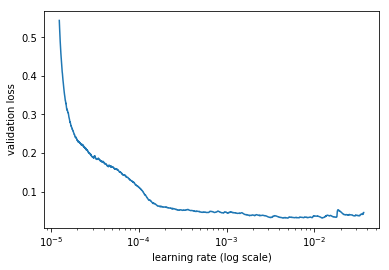

In [44]:
m.sched.plot(100)

In [45]:
lr = 1e-3

### Sample

In [46]:
## Try to to fit for 3 epochs
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.013036   0.023531   0.135229  
    1      0.011327   0.012807   0.10854                                                                               
    2      0.009783   0.011885   0.104033                                                                              


[array([0.01188]), 0.10403285187928597]

In [47]:
lr=8e-5
lr

8e-05

In [48]:
## Training some more time but this time with SCGDR (Stochastic Gradient Descent with restart using cycle_len = 1)
##for testing updating learning rate to 8*(1e-5)
lr = 8e-5
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.007077   0.011467   0.100159  
    1      0.006979   0.011427   0.099812                                                                              
    2      0.007075   0.011402   0.099629                                                                              
    3      0.007447   0.011361   0.099457                                                                              
    4      0.006635   0.011366   0.099393                                                                              


[array([0.01137]), 0.09939349411187505]

In [207]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4, cycle_mult=1)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.006919   0.011095   0.099168  
    1      0.006588   0.011083   0.099251                                                                              
    2      0.007069   0.011212   0.099146                                                                              
    3      0.006337   0.011145   0.099175                                                                              
    4      0.006754   0.010876   0.09868                                                                               
    5      0.006933   0.011068   0.09909                                                                               
    6      0.006236   0.01128    0.099058                                                                              
    7      0.006491   0.011088   0.098755                                                                           

[array([0.01109]), 0.09875472012217329]

##### Since we are overfitting,  I will try to increase the dropout proportionally and use batch normalization. Re-run the same fittings above to see if improve things.
##### Currently we are getting a trn_loss = 0.006933, validation_loss=0.01128, exp_rmsp = 0.098755

In [54]:
## Get learner object with increase drop out and batch normalization. By default get_learner leverages Adam optimizer.
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.14, 1, [1000,500], [0.01,0.1], y_range=y_range)

 58%|█████████████████████████████████████▏                          | 3657/6297 [00:32<00:23, 112.71it/s, loss=0.0756]

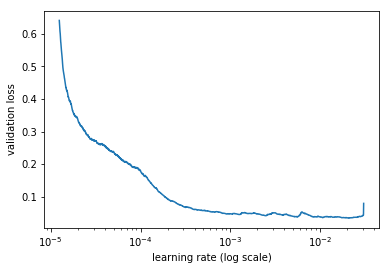

In [55]:
m.lr_find()
m.sched.plot(100)

In [56]:
#changing learning rate based upon the the above plot.
lr = 1e-4

In [57]:
m.fit(lr, 4, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.050168   0.052555   0.199737  
    1      0.028728   0.032735   0.159691                                                                              
    2      0.021505   0.024399   0.138093                                                                              
    3      0.018162   0.021074   0.1294                                                                                


[array([0.02107]), 0.1293996360815868]

In [58]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=4, cycle_mult=1)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.017359   0.021239   0.128896  
    1      0.014871   0.016865   0.116695                                                                              
    2      0.013871   0.015746   0.113662                                                                              
    3      0.012884   0.016892   0.116863                                                                              
    4      0.013856   0.015314   0.112853                                                                              
    5      0.012428   0.015122   0.11188                                                                               
    6      0.011478   0.014525   0.109917                                                                              
    7      0.013172   0.014489   0.110005                                                                           

[array([0.01327]), 0.10679539627718658]

In [59]:
m.fit(lr, 4, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                                                                             
    0      0.010544   0.013185   0.106216  
    1      0.011057   0.012971   0.105726                                                                              
    2      0.0106     0.012866   0.105755                                                                              
    3      0.010677   0.012731   0.105196                                                                              


[array([0.01273]), 0.10519606424195839]

In [60]:
m.save('val0')

In [61]:
m.load('val0')

In [62]:
x,y=m.predict_with_targs()

In [63]:
exp_rmspe(x,y)

0.10909381126652322

In [64]:
pred_test=m.predict(True)

In [65]:
pred_test = np.exp(pred_test)

In [66]:
pred_test

array([[ 4386.972 ],
       [ 7271.528 ],
       [ 9305.314 ],
       [ 6538.0654],
       [ 7277.994 ],
       [ 5862.8643],
       [ 7858.8506],
       [ 8099.105 ],
       [ 5365.1055],
       [ 5688.832 ],
       [ 7220.137 ],
       [ 8471.486 ],
       [ 7240.9414],
       [ 8527.439 ],
       [ 6074.691 ],
       [ 4595.355 ],
       [ 5932.862 ],
       [ 9909.405 ],
       [10924.114 ],
       [ 9821.484 ],
       ...,
       [ 7852.55  ],
       [14039.515 ],
       [ 5857.605 ],
       [ 5349.196 ],
       [ 7632.3945],
       [ 8376.672 ],
       [ 3151.0122],
       [ 9201.054 ],
       [ 6919.1465],
       [ 5454.2   ],
       [ 5735.9277],
       [ 4734.9463],
       [ 3369.098 ],
       [ 5513.027 ],
       [ 3964.497 ],
       [ 3145.713 ],
       [ 7716.532 ],
       [ 6516.341 ],
       [23775.96  ],
       [ 7248.2305]], dtype=float32)

In [67]:
joined_test['Sales']=pred_test

In [68]:
csv_fn=f'{PATH}tmp/sub.csv'

In [69]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [71]:
display(joined_test.head(10))
display(joined.head(10))

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Id
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,2015,9,17,False,24,0,c,a,...,14.0,6.0,69.0,67.0,105.0,0.0,1.0,0.0,4386.972168,1
2015-09-17,3,4,2015,9,17,False,24,25,a,a,...,26.0,6.0,68.0,67.0,105.0,0.0,1.0,0.0,7271.527832,2
2015-09-17,7,4,2015,9,17,False,24,0,a,c,...,14.0,5.0,59.0,67.0,115.0,0.0,1.0,0.0,9305.314453,3
2015-09-17,8,4,2015,9,17,False,11,0,a,a,...,14.0,5.0,59.0,67.0,115.0,0.0,1.0,0.0,6538.065430,4
2015-09-17,9,4,2015,9,17,False,24,0,a,c,...,26.0,6.0,68.0,67.0,105.0,0.0,1.0,0.0,7277.994141,5
2015-09-17,10,4,2015,9,17,False,24,0,a,a,...,29.0,6.0,70.0,67.0,115.0,0.0,1.0,0.0,5862.864258,6
2015-09-17,11,4,2015,9,17,False,24,25,a,c,...,14.0,5.0,59.0,67.0,115.0,0.0,1.0,0.0,7858.850586,7
2015-09-17,12,4,2015,9,17,False,0,25,a,c,...,14.0,5.0,59.0,67.0,115.0,0.0,1.0,0.0,8099.104980,8
2015-09-17,13,4,2015,9,17,False,0,25,d,a,...,13.0,6.0,62.0,67.0,33.0,0.0,1.0,0.0,5365.105469,9


,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date
0,1,5,2015,7,31,False,24,0,c,a,...,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263,2015-07-31
1,2,5,2015,7,31,False,24,25,a,a,...,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064,2015-07-31
2,3,5,2015,7,31,False,24,25,a,a,...,5.0,2.0,86.0,83.0,57.0,0.0,1.0,1.0,8314,2015-07-31
3,4,5,2015,7,31,False,24,0,c,c,...,16.0,6.0,74.0,83.0,67.0,0.0,1.0,1.0,13995,2015-07-31
4,5,5,2015,7,31,False,3,0,a,a,...,11.0,4.0,82.0,83.0,57.0,0.0,1.0,1.0,4822,2015-07-31
5,6,5,2015,7,31,False,19,0,a,a,...,11.0,4.0,82.0,83.0,57.0,0.0,1.0,1.0,5651,2015-07-31
6,7,5,2015,7,31,False,24,0,a,c,...,13.0,6.0,77.0,83.0,67.0,0.0,1.0,1.0,15344,2015-07-31
7,8,5,2015,7,31,False,9,0,a,a,...,13.0,6.0,77.0,83.0,67.0,0.0,1.0,1.0,8492,2015-07-31
8,9,5,2015,7,31,False,24,0,a,c,...,5.0,2.0,86.0,83.0,57.0,0.0,1.0,1.0,8565,2015-07-31
9,10,5,2015,7,31,False,24,0,a,a,...,13.0,5.0,80.0,83.0,67.0,0.0,1.0,1.0,7185,2015-07-31


In [228]:
FileLink(csv_fn)

C:\Varun\Project\fastai\courses\dl1\data\rossmann-store-sales\tmp\sub.csv